In [2]:
import os
os.chdir('/project/ssverma_shared/projects/Endometriosis/Endo_Subtyping_Heterogeneity/Cluster_Training/')
import pandas as pd
import matplotlib as mpl
import numpy as np
np.seterr(divide = 'ignore')


mpl.rcParams['figure.dpi'] = 120

%config IPCompleter.use_jedi = False
%matplotlib inline

In [3]:
import numpy as np

from matplotlib import pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import KNeighborsClassifier
from sklearn.manifold import TSNE
import seaborn as sns
from upsetplot import plot
import pickle

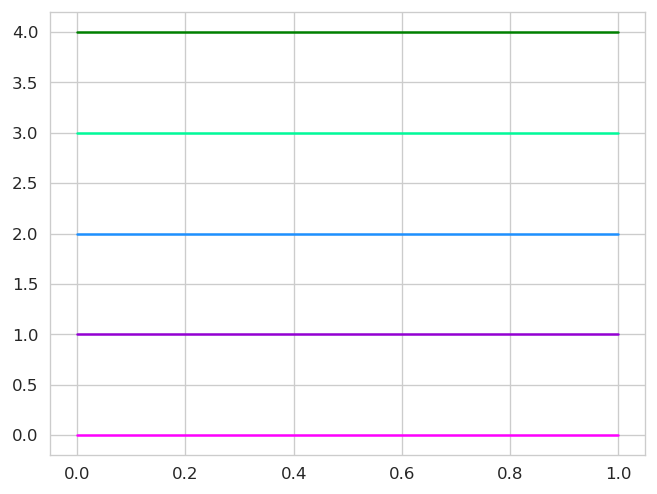

In [4]:
# Set up color palette to use for the five clusters
colors = ['fuchsia',
          'darkviolet',
          # 'navy',
          'dodgerblue',
          'mediumspringgreen',
          'g']

mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=colors)

for i in range(len(colors)):
    plt.plot([0, 1], [i, i])

plt.show()

In [10]:
# Check if Snakemake files are up-to-date
! snakemake -n all --quiet

Building DAG of jobs...
Nothing to be done (all requested files are present and up to date).


In [11]:
features = pd.read_csv('Data/non_genotyped_PMBB_data_for_no_snps_clustering.csv', index_col='IID', dtype={'IID': str})

In [12]:
geno_pheno = pd.read_csv('Pheno/PMBB_all_cleaned_phenos.csv', index_col='PMBB_ID', low_memory=False)
pheno = pd.read_csv('Pheno/FULL_PMBB_all_cleaned_phenos.csv', index_col='PMBB_ID', low_memory=False)
pheno = pheno[~pheno.index.isin(geno_pheno.index)]

pheno[[c for c in pheno.columns if 'CC3' in c]] = pheno[[c for c in pheno.columns if 'CC3' in c]].apply(lambda x: pd.to_numeric(x, errors='coerce'))

use_pheno = 'ICD_1_with_N80.0'

cases = pheno.index[pheno[use_pheno] == 1]
controls = pheno.index[pheno[use_pheno] == 0]

cases = cases.intersection(features.index)

pheno = pheno[pheno.index.isin(cases) | pheno.index.isin(controls)]

print(len(controls), len(cases))

pheno[use_pheno].fillna('NA').value_counts()

104967 4626


0    104967
1      4626
Name: ICD_1_with_N80.0, dtype: int64

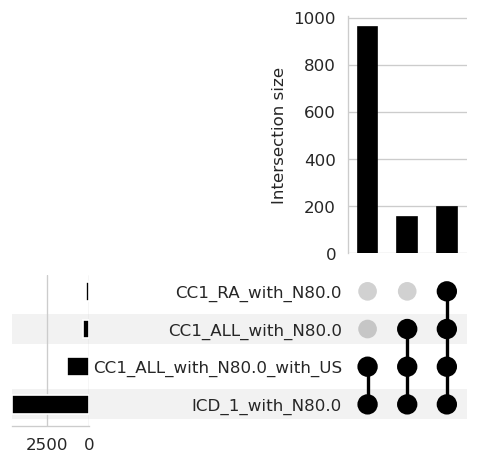

,0,1,NA
ICD_1_with_N80.0,104967.0,4626.0,NaN
CC1_ALL_with_N80.0_with_US,26416.0,1310.0,81867.0
CC1_ALL_with_N80.0,2150.0,350.0,107093.0
CC1_RA_with_N80.0,1204.0,195.0,108194.0


In [13]:
use_cols = ['ICD_1_with_N80.0',
            'CC1_ALL_with_N80.0_with_US',
            'CC1_ALL_with_N80.0',
            'CC1_RA_with_N80.0']

plot(pheno[use_cols].fillna(0).value_counts(),
     max_subset_size=1000)
plt.show()

pheno[use_cols].fillna('NA').apply(lambda x: x.value_counts(), result_type='expand').transpose()

In [14]:
pheno.loc[features.index, 'RACE'].value_counts()

White                                        3153
Black or African American                    1004
Unknown or Not Reported                       218
Asian                                         184
More than One Race                             61
Native Hawaiian or Other Pacific Islander       3
American Indian or Alaska Native                3
Name: RACE, dtype: int64

In [15]:
view_cols = ['CC1_ALL', 'CC2_ALL', 'CC1_RA', 'CC2_RA',
             'CC1_ALL_with_N80.0', 'CC2_ALL_with_N80.0', 'CC1_RA_with_N80.0', 'CC2_RA_with_N80.0',
             'ICD_1', 'ICD_2', 'ICD_1_with_N80.0', 'ICD_2_with_N80.0',
             'endometriosis', 'uterine_endometriosis', 'not_uterine_endometriosis',
             'CC1_ALL_with_N80.0_with_US', 'CC2_ALL_with_N80.0_with_US',
             'CC1_RA_with_N80.0_with_US', 'CC2_RA_with_N80.0_with_US']

pheno[view_cols].apply(lambda x: x.value_counts(), result_type='expand').transpose().sort_values(by=1, ascending=False)

,0.0,1.0
ICD_1_with_N80.0,104967,4626
endometriosis,104967,4626
ICD_1,106522,3071
not_uterine_endometriosis,104967,2519
uterine_endometriosis,107486,2107
CC2_ALL_with_N80.0_with_US,106297,1310
CC1_ALL_with_N80.0_with_US,26416,1310
ICD_2_with_N80.0,108717,876
CC2_RA_with_N80.0_with_US,107707,747
CC1_RA_with_N80.0_with_US,18571,747


In [16]:
feature_cols = [c for c in pheno.columns if 'icd' not in c and ('age' not in c.lower() or c == 'miscarriage') and 'PC' not in c and 'ANCESTRY' not in c and 'SEX' not in c and 'Related' not in c]
feature_cols = [c for c in feature_cols if c[-5:] != '_last' and c[-6:] != '_first' and c[-5:].lower() != '_mean']

feature_df = pheno.loc[cases, feature_cols].copy()

binary_cols = [c for c in feature_df.columns if len(feature_df[c].dropna().unique()) == 2]
drop_binary_cols = [c for c in binary_cols if feature_df[c].mean() < 0.01 or 'CC' in c or 'ICD' in c or 'endo_N' in c]
drop_binary_cols.extend([c for c in binary_cols if 'pregnancy_symptoms' in c])

feature_df = feature_df.drop(columns=drop_binary_cols)
binary_cols = [c for c in binary_cols if c not in drop_binary_cols]

cont_cols = [c for c in feature_df.columns if c not in binary_cols and len(feature_df[c].unique()) > 2]

print(binary_cols)
print(drop_binary_cols)
print(cont_cols)

long_term_outcomes = [c for c in binary_cols if 'cancer' in c]
long_term_outcomes.extend([c for c in binary_cols if 'infarction' in c])
long_term_outcomes.append('ischemic_heart_disease_acute')
long_term_outcomes.append('melanoma')
long_term_outcomes.append('infertility')
long_term_outcomes.append('pregnancy_with_abortive_outcome')
long_term_outcomes.append('miscarriage')
long_term_outcomes.append('hypertensive_pregnancy_issues')

risk_factor_cols = sorted([c for c in binary_cols if 'endo' not in c and 'pregnancy_symptoms' not in c and c not in long_term_outcomes])
risk_factor_cols.remove('ulcerative_colitis')
risk_factor_cols.remove('crohns')

['uterine_endometriosis', 'female_organ_cancer', 'breast_cancer', 'ovarian_cancer', 'uterine_cancer', 'melanoma', 'thyroid_cancer', 'leiomyoma_of_uterus', 'pcos', 'type_2_diabetes', 'abnormal_cholesterol', 'hypertension', 'acute_myocardial_infarction', 'ischemic_heart_disease_chronic', 'cerebral_infarction', 'dysmenorrhea', 'pain_with_sex', 'infertility', 'high_risk_pregnancy_supervision', 'hypertensive_pregnancy_issues', 'uncomplicated_delivery_encounter', 'pregnancy_with_abortive_outcome', 'miscarriage', 'abdominal_pelvic_pain', 'pelvic_perineal_pain', 'lower_abdominal_pain', 'dysuria', 'fibromyalgia', 'migraine', 'ibs', 'crohns', 'ulcerative_colitis', 'interstitial_cystitis', 'irregular_menstruation', 'rheumatoid_arthritis', 'systemic_lupus_erythematosus', 'asthma']
['ICD_1', 'ICD_2', 'ICD_2_with_N80.0', 'CC1_ALL', 'CC2_ALL', 'CC3_ALL', 'CC1_RA', 'CC2_RA', 'CC3_RA', 'CC2_ALL_with_N80.0', 'CC3_ALL_with_N80.0', 'CC1_RA_with_N80.0', 'CC2_RA_with_N80.0', 'CC3_RA_with_N80.0', 'CC1_ALL_wi

                   PMBB3609358940318  PMBB4129474596215  PMBB9667788732981
IID                                                                       
PMBB3609358940318           0.000000           0.000002           0.000011
PMBB4129474596215           0.000002           0.000000           0.000010
PMBB9667788732981           0.000011           0.000010           0.000000
count    4615.000000
mean        0.290927
std         0.047155
min         0.213263
25%         0.251351
50%         0.288744
75%         0.324432
max         0.633746
dtype: float64
Index(['PMBB1416649647121', 'PMBB5722341073505', 'PMBB5746993427018',
       'PMBB5894725453370', 'PMBB6404034341995', 'PMBB6992295714524',
       'PMBB8185536298517'],
      dtype='object')
count    4608.000000
mean        0.290266
std         0.046391
min         0.212860
25%         0.250861
50%         0.288366
75%         0.324113
max         0.417717
dtype: float64


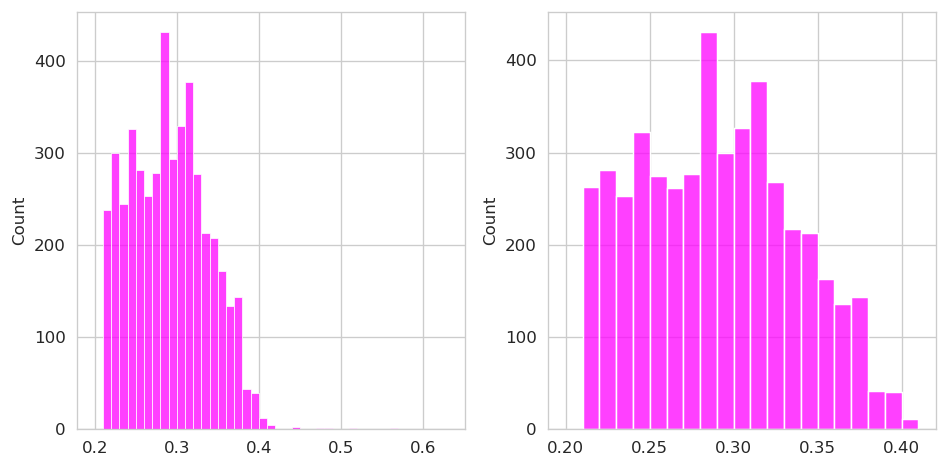

,PMBB1001462384555,PMBB1002857391938,PMBB1003222496744,PMBB1003626451826,PMBB1004325391026,PMBB1005252976083,PMBB1006656964324,PMBB1011916439505,PMBB1012175794211,PMBB1014590081040,...,PMBB9986010294976,PMBB9986963986959,PMBB9987125538976,PMBB9987252371205,PMBB9991089432357,PMBB9991994966750,PMBB9994756680249,PMBB9995182887713,PMBB9997370924922,PMBB9998857962671
IID,,,,,,,,,,,,,,,,,,,,,
PMBB1001462384555,0.000000,0.169234,0.343013,0.400756,0.291564,0.345260,0.268581,0.275232,0.331922,0.380593,...,0.182468,0.409226,0.357196,0.279633,0.243779,0.011154,0.216184,0.070530,0.393088,0.199730
PMBB1002857391938,0.169234,0.000000,0.184369,0.335827,0.248128,0.222597,0.243803,0.169791,0.351118,0.313056,...,0.203225,0.302316,0.236177,0.337210,0.114219,0.161154,0.172527,0.131273,0.337599,0.056811
PMBB1003222496744,0.343013,0.184369,0.000000,0.430385,0.378438,0.275909,0.387285,0.270047,0.375249,0.409281,...,0.284454,0.354597,0.117596,0.507495,0.217730,0.336688,0.322704,0.291178,0.440756,0.195980
PMBB1003626451826,0.400756,0.335827,0.430385,0.000000,0.110286,0.158099,0.138721,0.170040,0.683891,0.022797,...,0.529401,0.104743,0.534148,0.252051,0.229586,0.390774,0.186019,0.411476,0.022073,0.281310
PMBB1004325391026,0.291564,0.248128,0.378438,0.110286,0.000000,0.149710,0.032885,0.111047,0.586432,0.092164,...,0.429834,0.157031,0.468552,0.177108,0.161184,0.281778,0.080966,0.306283,0.101645,0.199856
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PMBB9991994966750,0.011154,0.161154,0.336688,0.390774,0.281778,0.334833,0.259153,0.264804,0.337339,0.370532,...,0.186083,0.398749,0.353983,0.273971,0.233647,0.000000,0.206093,0.069917,0.383293,0.190216
PMBB9994756680249,0.216184,0.172527,0.322704,0.186019,0.080966,0.156952,0.071296,0.089043,0.505626,0.165129,...,0.348912,0.200926,0.401822,0.190032,0.110237,0.206093,0.000000,0.226208,0.180810,0.131038
PMBB9995182887713,0.070530,0.131273,0.291178,0.411476,0.306283,0.332975,0.288429,0.267449,0.290360,0.389956,...,0.134888,0.404553,0.298700,0.324851,0.225466,0.069917,0.226208,0.000000,0.406887,0.173471


In [65]:
tsne_dist_mtx = pd.read_csv('TSNE_Random_Avg_no_SNPs/avg_dist_mtx_0_200.csv', index_col='IID', dtype={'IID': str})

asymmetric = tsne_dist_mtx.loc[np.any(tsne_dist_mtx != tsne_dist_mtx.transpose(), axis=1),
                               np.any(tsne_dist_mtx != tsne_dist_mtx.transpose(), axis=0)]
print(asymmetric)

a_idx = asymmetric.index

# manually fix floating-point issues
for i, a1 in enumerate(asymmetric.index):
    for j, a2 in enumerate(asymmetric.index):
        if i >= j:
            continue
        tsne_dist_mtx.loc[a1, a2] = tsne_dist_mtx.loc[a2, a1]

# tsne_dist_mtx = pd.read_csv('PMBB/TSNE_Random_Avg_no_SNPs/avg_dist_mtx_0_200_KEEP_SAVE_061423.csv', index_col='IID', dtype={'IID': str})

fig, axes = plt.subplots(ncols=2)
fig.set_size_inches(8, 4)

mean_dist = tsne_dist_mtx.mean()
print(mean_dist.describe())
sns.histplot(mean_dist, bins=np.arange(0.2, mean_dist.max(), 0.01), ax=axes[0])

outliers = mean_dist.index[mean_dist > (mean_dist.mean() + 3 * mean_dist.std())]
tsne_dist_mtx = tsne_dist_mtx.loc[[i for i in tsne_dist_mtx.index if i not in outliers],
                                  [c for c in tsne_dist_mtx.columns if c not in outliers]]

print(outliers)

mean_dist = tsne_dist_mtx.mean()
print(mean_dist.describe())
sns.histplot(mean_dist, bins=np.arange(0.2, mean_dist.max(), 0.01), ax=axes[1])
plt.tight_layout()
plt.show()

features = features[~features.index.isin(outliers)]
tsne_dist_mtx

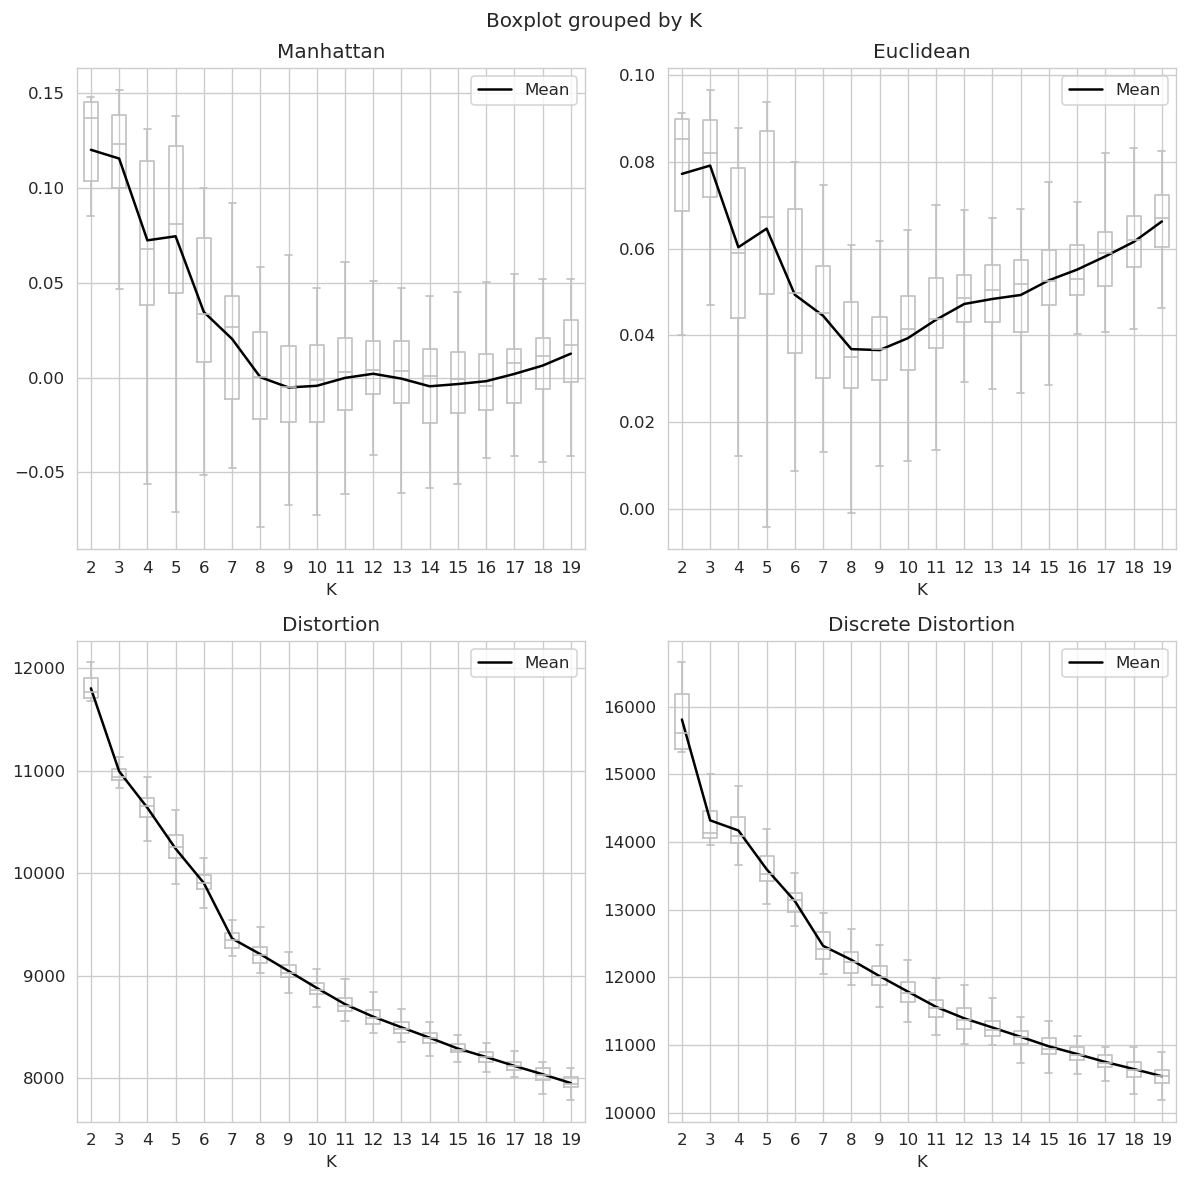

In [66]:
k_tests = pd.read_csv('Data/merged_k_tests_long.csv')

fig, axes = plt.subplots(ncols=2, nrows=2)

fig.set_size_inches(10, 10)

colorprops = {'boxes': 'silver',
              'whiskers': 'silver',
              'medians': 'silver',
              'caps': 'silver'}

k_tests.boxplot(['Manhattan'], by='K', showfliers=False, ax=axes[0][0], color=colorprops)
k_tests.boxplot(['Euclidean'], by='K', showfliers=False, ax=axes[0][1], color=colorprops)
k_tests.boxplot(['Distortion'], by='K', showfliers=False, ax=axes[1][0], color=colorprops)
k_tests.boxplot(['Discrete Distortion'], by='K', showfliers=False, ax=axes[1][1], color=colorprops)

axes[0][0].plot(np.arange(18)+1, k_tests.groupby('K')['Manhattan'].mean(), label='Mean', color='k')
axes[0][1].plot(np.arange(18)+1, k_tests.groupby('K')['Euclidean'].mean(), label='Mean', color='k')
axes[1][0].plot(np.arange(18)+1, k_tests.groupby('K')['Distortion'].mean(), label='Mean', color='k')
axes[1][1].plot(np.arange(18)+1, k_tests.groupby('K')['Discrete Distortion'].mean(), label='Mean', color='k')

for ax in axes.flatten():
    ax.legend()

plt.tight_layout()
plt.show()

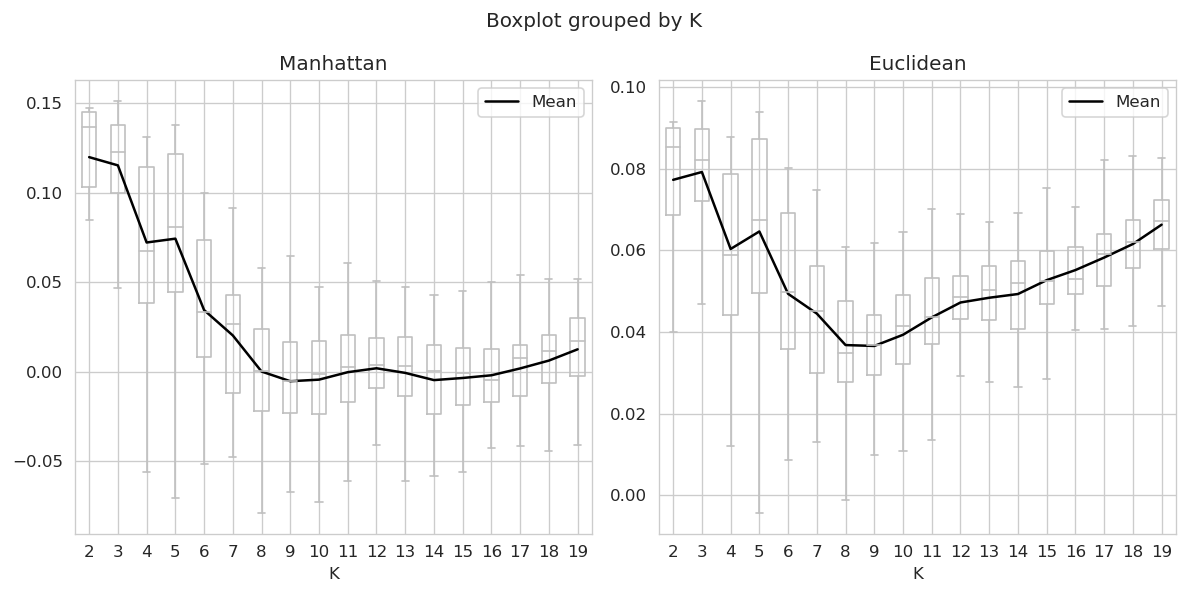

In [67]:
k_tests = pd.read_csv('Data/merged_k_tests_long.csv')

fig, axes = plt.subplots(ncols=2, nrows=1)

fig.set_size_inches(10, 5)

k_tests.boxplot(['Manhattan'], by='K', showfliers=False, ax=axes[0], color=colorprops)
k_tests.boxplot(['Euclidean'], by='K', showfliers=False, ax=axes[1], color=colorprops)

axes[0].plot(np.arange(18)+1, k_tests.groupby('K')['Manhattan'].mean(), label='Mean', c='k')
axes[1].plot(np.arange(18)+1, k_tests.groupby('K')['Euclidean'].mean(), label='Mean', c='k')

for ax in axes.flatten():
    ax.legend()

plt.tight_layout()
plt.show()

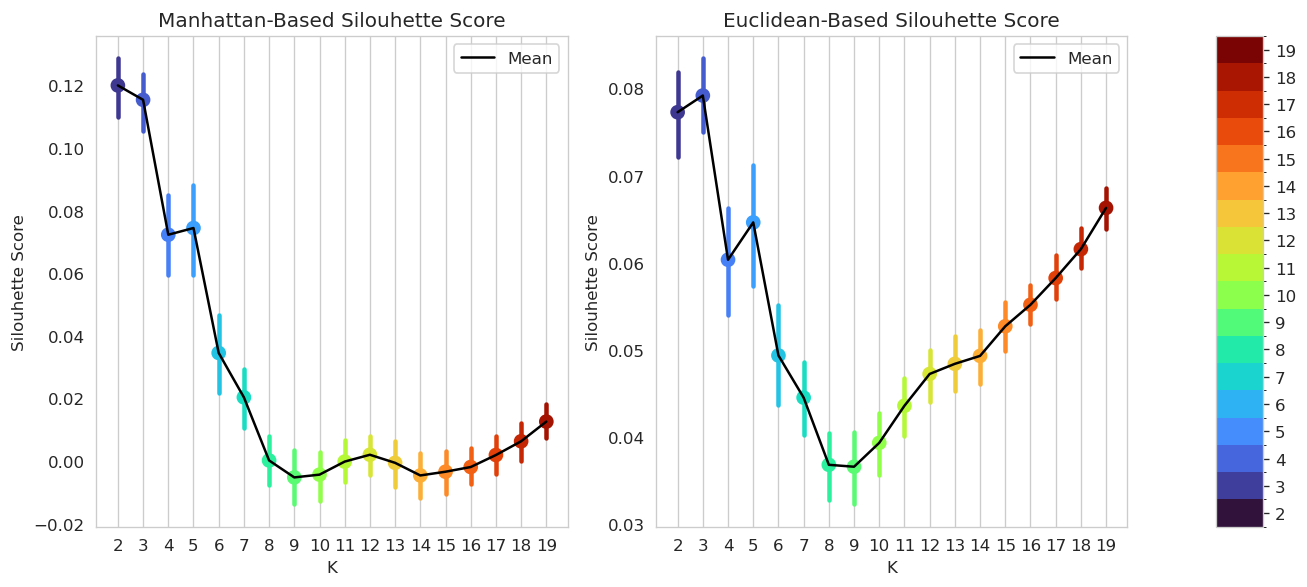

In [68]:
k_tests = pd.read_csv('Data/merged_k_tests_long.csv')

fig, axes = plt.subplots(ncols=3, nrows=1, gridspec_kw={'width_ratios': [1, 1, 0.1]})

fig.set_size_inches(11, 5)

sns.pointplot(data=k_tests, x='K', y='Manhattan', palette='turbo', ax=axes[0])
sns.pointplot(data=k_tests, x='K', y='Euclidean', palette='turbo', ax=axes[1])

# norm = mpl.colors.Normalize(vmin=2, vmax=19)
norm = mpl.colors.BoundaryNorm(np.arange(1.5, 20.5), ncolors=256)
sm = mpl.cm.ScalarMappable(norm, cmap='turbo')
plt.colorbar(sm, cax=axes[2])
axes[2].set_yticks(np.arange(2, 20))

axes[0].plot(np.arange(18), k_tests.groupby('K')['Manhattan'].mean(), label='Mean', c='k')
axes[1].plot(np.arange(18), k_tests.groupby('K')['Euclidean'].mean(), label='Mean', c='k')

axes[0].grid()
axes[1].grid()

axes[0].set_ylabel('Silouhette Score')
axes[1].set_ylabel('Silouhette Score')

axes[0].set_title('Manhattan-Based Silouhette Score')
axes[1].set_title('Euclidean-Based Silouhette Score')

for ax in axes[:2].flatten():
    ax.legend()

plt.tight_layout()
plt.savefig('Plots/pointplots_NG_PMBB_silouhette_scores_k_tests.png', bbox_inches='tight')
plt.show()

In [84]:
best_k = 5
k = 5

model = AgglomerativeClustering(n_clusters=k,
                                affinity='precomputed',
                                linkage='complete')

clusters = pd.Series(model.fit_predict(tsne_dist_mtx), index=tsne_dist_mtx.index)
clusters = clusters.replace({0: 2,
                             1: 0,
                             2: 1,
                             3: 3,
                             4: 4})
print(clusters.value_counts().sort_index())

0     821
1     882
2    1316
3     726
4     863
dtype: int64


In [85]:
clusters.name = 'Cluster'
clusters.to_csv('Data/KEEP_NG_PMBB_clusters.csv')

In [86]:
tsne = TSNE(n_components=2, init='pca', perplexity=50, random_state=314159, metric='manhattan')

embedding = pd.DataFrame(tsne.fit_transform(features),
                         columns=['TSNE 1', 'TSNE 2'],
                         index=features.index)

/home/guarelin/mambaforge/envs/py38/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/guarelin/mambaforge/envs/py38/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


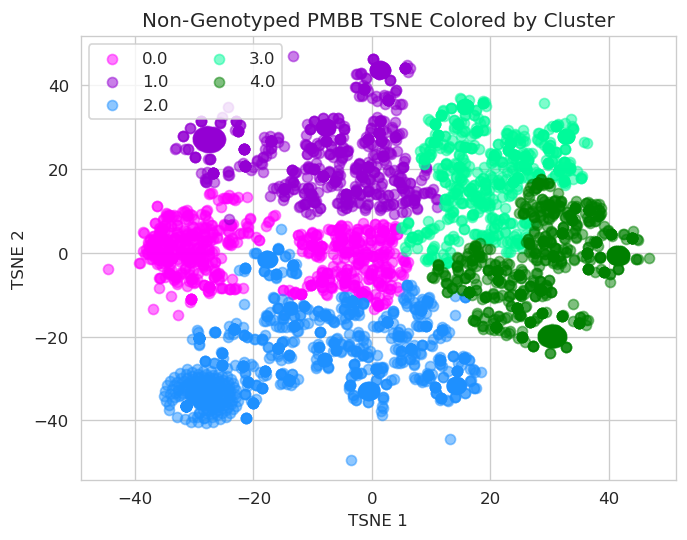

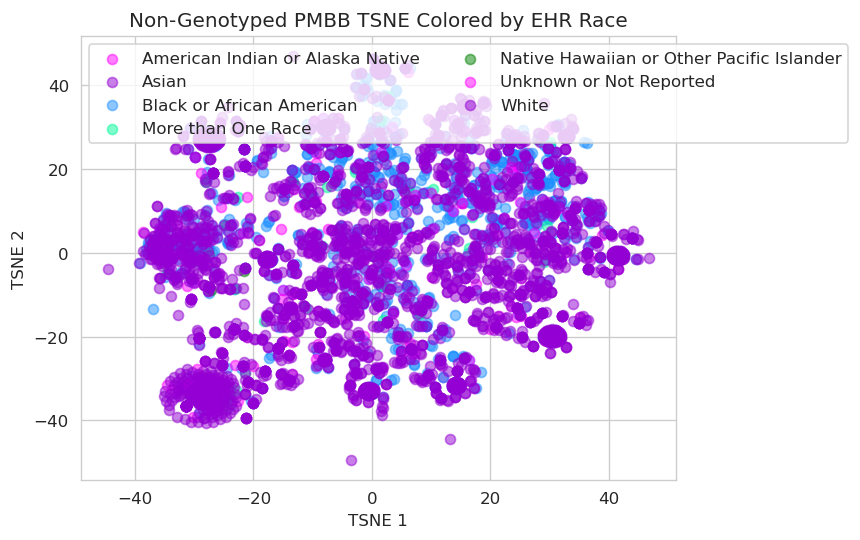

In [87]:
for cluster, subDF in embedding.groupby(clusters):
    plt.scatter(subDF['TSNE 1'], subDF['TSNE 2'], label=cluster, alpha=0.5)

plt.ylabel('TSNE 2')
plt.xlabel('TSNE 1')

plt.legend(loc='upper left', ncol=2)

plt.title('Non-Genotyped PMBB TSNE Colored by Cluster')
plt.savefig('Plots/no_snps_scatter_NG_PMBB_TSNE_Clusters.png', dpi=150, bbox_inches='tight')
plt.show()

"""
for cluster, subDF in embedding.groupby(real_clusters):
    plt.scatter(subDF['TSNE 1'], subDF['TSNE 2'], label=cluster, alpha=0.5)

plt.ylabel('TSNE 2')
plt.xlabel('TSNE 1')

plt.legend(loc='upper left', ncol=2)

plt.title('Non-Genotyped PMBB TSNE Colored by Cluster')
plt.show()
"""

for cluster, subDF in embedding.groupby(pheno['RACE']):
    plt.scatter(subDF['TSNE 1'], subDF['TSNE 2'], label=cluster, alpha=0.5)

plt.legend()
plt.ylabel('TSNE 2')
plt.xlabel('TSNE 1')

plt.legend(loc='upper left', ncol=2)

plt.title('Non-Genotyped PMBB TSNE Colored by EHR Race')
plt.savefig('Plots/no_snps_scatter_NG_PMBB_TSNE_Race.png', dpi=150, bbox_inches='tight')
plt.show()

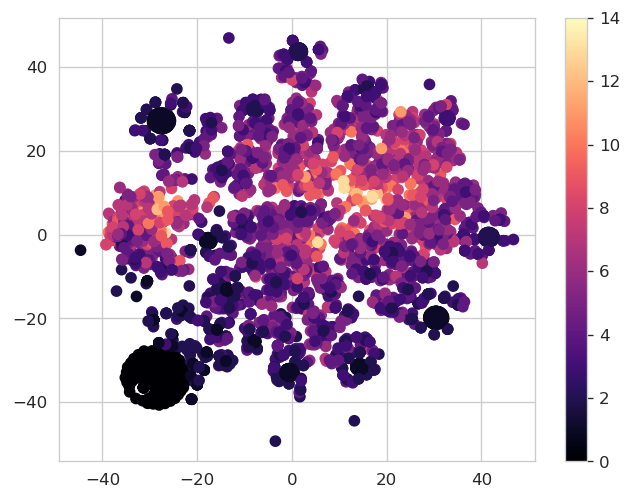

In [88]:
plt.scatter(embedding.loc[features.index, 'TSNE 1'],
            embedding.loc[features.index, 'TSNE 2'],
            c=features.sum(axis=1), cmap='magma')
plt.colorbar()
plt.show()

In [89]:
transfer_clusters = KNeighborsClassifier(n_neighbors=3, weights='distance',
                                         metric='manhattan', algorithm='brute')

transfer_clusters.fit(features.loc[clusters.index], clusters)

os.makedirs('Models/', exist_ok=True)
pickle.dump(transfer_clusters, open('Models/non_geno_PMBB_transfer_clusters.pickle', 'wb+'))

test_transfer = pickle.load(open('Models/non_geno_PMBB_transfer_clusters.pickle', 'rb'))
test_transfer.predict(features.loc[clusters.index])

training_y = transfer_clusters.predict(features.loc[clusters.index])

pd.crosstab(clusters, training_y)

col_0,0,1,2,3,4
Cluster,,,,,
0,821,0,0,0,0
1,0,882,0,0,0
2,0,0,1316,0,0
3,0,0,0,726,0
4,0,0,0,0,863


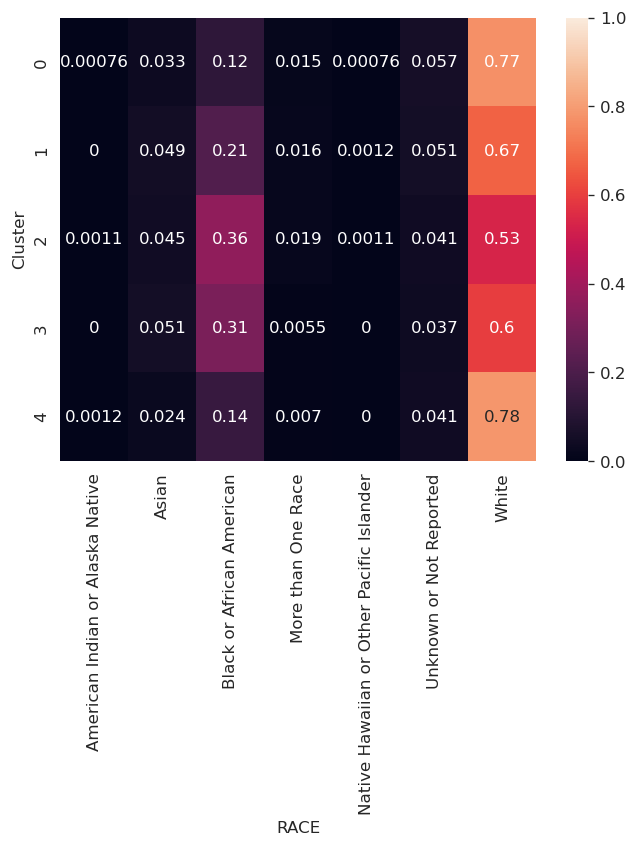

In [75]:
cluster_by_ancestry = pd.crosstab(pheno['RACE'], clusters)
cluster_by_ancestry.columns.name = 'Cluster'
sns.heatmap((cluster_by_ancestry / cluster_by_ancestry.sum()).transpose(),
            vmin=0, vmax=1, annot=True)
plt.show()